<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/sentiment_classification/Basic%20Sentimix%20using%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [131]:
!pip install contractions -q

Dataset can be found [here](https://github.com/gopalanvinay/thesis-vinay-gopalan)

In [51]:
train_file = '/content/drive/My Drive/train_14k_split_conll.txt'
test_file = '/content/drive/My Drive/dev_3k_split_conll.txt'

### Imports

In [128]:
import re
import time
import string
import contractions
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
with open(train_file) as f:
    data = f.readlines()

In [54]:
with open(test_file, 'r') as f:
    test_data = f.readlines()

### Data Parsing

In [55]:
def parse_data(data):
    sentences, sentences_info, sentiment = [], [], []
    all_langs = []
    
    single_sentence, single_sentence_info = [], []
    sent = ""
    
    for idx, each_line in enumerate(data):
        line = each_line.strip()
        tokens = line.split('\t')
        num_tokens = len(tokens)
        if num_tokens == 2:
            # add the word
            single_sentence.append(tokens[0])
            # add the word info(lang)
            single_sentence_info.append(tokens[1])
            all_langs.append(tokens[1])
        elif num_tokens == 3 and idx > 0:
            # append the sentence data
            sentences.append(single_sentence)
            sentences_info.append(single_sentence_info)
            sentiment.append(sent)
            sent = tokens[-1]
            # clear the single sentence
            single_sentence = []
            single_sentence_info = []
        # new line after the sentence
        elif num_tokens == 1:
            continue
        else:
            sent = tokens[-1]
    # for the last sentence
    if len(single_sentence) > 0:
        sentences.append(single_sentence)
        sentences_info.append(single_sentence_info)
        sentiment.append(sent)
        
    assert len(sentences) == len(sentences_info) == len(sentiment)
    return sentences, sentences_info, sentiment, all_langs

In [56]:
sentences, sentences_info, sentiment, all_langs = parse_data(data)

In [57]:
data[:30]

['meta\t4330\tneutral\n',
 'nen\tEng\n',
 'á\tO\n',
 'vist\tEng\n',
 'bolest\tEng\n',
 'vztek\tEng\n',
 'smutek\tEng\n',
 'zmatek\tHin\n',
 'osam\tHin\n',
 'ě\tO\n',
 'lost\tEng\n',
 'beznad\tEng\n',
 'ě\tO\n',
 'j\tHin\n',
 'a\tEng\n',
 'nakonec\tEng\n',
 'jen\tHin\n',
 'klid\tHin\n',
 'Asi\tHin\n',
 'takhle\tHin\n',
 'vypad\tHin\n',
 'á\tO\n',
 'm\tHin\n',
 'ů\tO\n',
 'j\tEng\n',
 'life\tEng\n',
 '...\tO\n',
 '\n',
 'meta\t41616\tneutral\n',
 '@\tO\n']

In [58]:
test_sentences, test_sentences_info, test_sentiment, test_all_langs = parse_data(test_data)

In [59]:
len(sentiment)

14000

### Data Exploration

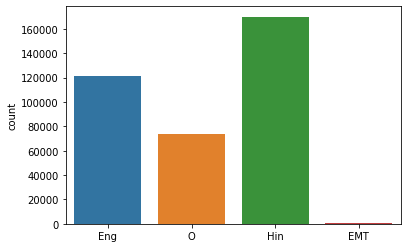

In [62]:
sns.countplot(all_langs)

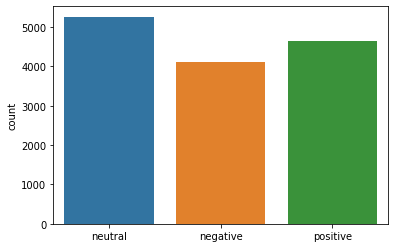

In [63]:
sns.countplot(sentiment)

In [64]:
set(sentiment)

{'negative', 'neutral', 'positive'}

In [65]:
sent_num_tokens = [len(sent) for sent in sentences]

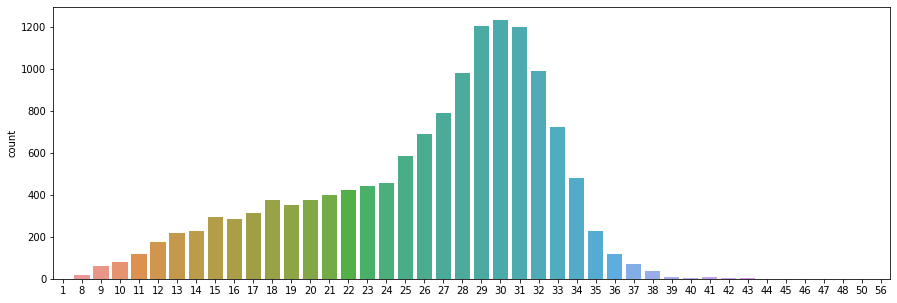

In [66]:
plt.figure(figsize=(15, 5))
sns.countplot(sent_num_tokens)

In [67]:
sentences[10]

['@',
 'ECISVEEP',
 'Can',
 'you',
 'answer',
 'miscalculated',
 'votes',
 'on',
 'each',
 'seat',
 '?',
 'One',
 'vote',
 'matters',
 '!',
 '#',
 'deshkamahatyohar',
 'hai',
 'aur',
 'apne',
 'dhji',
 '…',
 'https',
 '//',
 't',
 '.',
 'co',
 '/',
 'SuHS4mx6Dm']

In [68]:
sentences_info[10]

['O',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'Eng',
 'O',
 'Eng',
 'Eng',
 'Hin',
 'O',
 'O',
 'Hin',
 'Hin',
 'Hin',
 'Hin',
 'Eng',
 'O',
 'Eng',
 'O',
 'Eng',
 'O',
 'Hin',
 'O',
 'Hin']

In [69]:
sentiment[0]

'neutral'

### Data Cleaning

In [70]:
url_pattern = r'https(.*)/\s\w+'
special_chars = r'[_…\*\[\]\(\)&“]'
names_with_numbers = r'([A-Za-z]+)\d{3,}'
apostee = r"([\w]+)\s'\s([\w]+)"
names = r"@[\s]*[\w]+[\s]*[_]+[\s]*[\w]+|@[\s]*[\w]+"

def preprocess_data(sentence_tokens):
    sentence = " ".join(sentence_tokens)
    sentence = " " + sentence
    # remove rt and … from string
    sentence = sentence.replace(" RT ", "")
    sentence = sentence.replace("…", "")
    # replace apostee
    sentence = sentence.replace("’", "'")
    # replace names
    sentence = re.sub(re.compile(names), " ", sentence)
    # remove special chars
    # sentence = re.sub(re.compile(special_chars), "", sentence)
    # remove urls
    sentence = re.sub(re.compile(url_pattern), "", sentence)
    ## remove duplicate characters
    # sentence = re.sub(r"(.)\1{3,}", r'\1', sentence)
    # combine only ' related words => ... it ' s ... -> ... it's ...
    sentence = re.sub(re.compile(apostee), r"\1'\2", sentence)
    # fix contractions
    sentence = contractions.fix(sentence)
    # replace names ending with numbers with only names (remove numbers)
    sentence = re.sub(re.compile(names_with_numbers), r" ", sentence)
    ## consider only printable chars (many greek, urdu, hindi chars are there)
    # sentence = [ch for ch in sentence if ch in string.printable]
    # sentence = "".join(sentence).strip()
    sentence = " ".join(sentence.split()).strip()
    return sentence

In [71]:
" ".join(sentences[1]), sentiment[1]

('@ nehantics Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega … https // tco / 5RSlSbZNtt',
 'neutral')

In [72]:
preprocess_data(sentences[1])

'Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega'

In [73]:
" ".join(sentences[29]), sentiment[29]

('Madam @ SushmaSwaraj ji we always miss you as a # videsh _ mantri',
 'positive')

In [74]:
preprocess_data(sentences[29])

'Madam ji we always miss you as a # videsh _ mantri'

In [75]:
" ".join(sentences[10]), sentiment[10]

('@ ECISVEEP Can you answer miscalculated votes on each seat ? One vote matters ! # deshkamahatyohar hai aur apne dhji … https // t . co / SuHS4mx6Dm',
 'neutral')

In [76]:
preprocess_data(sentences[10])

'Can you answer miscalculated votes on each seat ? One vote matters ! # deshkamahatyohar hai aur apne dhji'

In [77]:
%%time
processed_sentences = []

for sent in sentences:
    processed_sentences.append(preprocess_data(sent))

CPU times: user 655 ms, sys: 4.01 ms, total: 659 ms
Wall time: 661 ms


In [85]:
%%time
test_data = []

for sent in test_sentences:
    test_data.append(preprocess_data(sent))

CPU times: user 153 ms, sys: 781 µs, total: 153 ms
Wall time: 155 ms


In [79]:
sentiment_mapping = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

In [83]:
labels = [sentiment_mapping[sent] for sent in sentiment]
test_label = [sentiment_mapping[sent] for sent in test_sentiment]

### Train-Val-Test Splits

In [87]:
train_data, val_data, train_label, val_label = train_test_split(processed_sentences, labels, test_size=0.2)

In [88]:
len(train_data), len(val_data), len(test_data)

(11200, 2800, 3000)

### Train-Val-Test Distributions

Text(0.5, 0, 'Training Data')

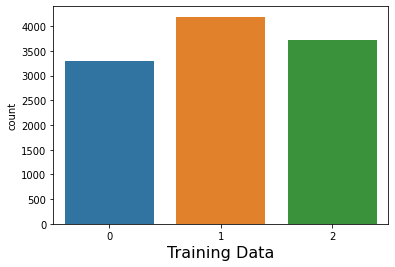

In [89]:
sns.countplot(train_label)
plt.xlabel('Training Data', fontsize=16)

Text(0.5, 0, 'Validation Data')

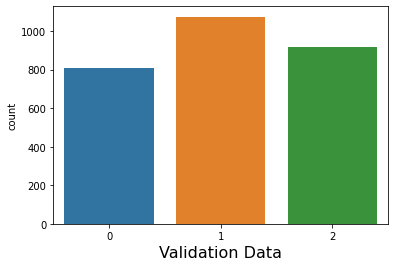

In [90]:
sns.countplot(val_label)
plt.xlabel('Validation Data', fontsize=16)

Text(0.5, 0, 'Testing Data')

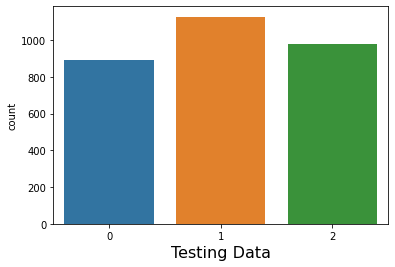

In [91]:
sns.countplot(test_label)
plt.xlabel('Testing Data', fontsize=16)

### Vocabulary

In [93]:
counter = Counter()
for line in train_data:
    tokens = line.strip().split()
    counter.update(tokens)

In [94]:
counter.most_common(10)

[('.', 3590),
 ('hai', 3108),
 ('ki', 2711),
 ('to', 2490),
 ('ko', 2162),
 ('nahi', 1879),
 ('you', 1776),
 ('is', 1675),
 ('ke', 1675),
 ('ka', 1649)]

In [95]:
MIN_FREQ = 15

In [96]:
vocab = []
for key in counter.most_common():
    if key[1] > MIN_FREQ:
        vocab.append(key[0])

In [97]:
len(vocab)

1521

In [98]:
vocab[:10]

['.', 'hai', 'ki', 'to', 'ko', 'nahi', 'you', 'is', 'ke', 'ka']

### Input Vectors (Bag-of-words)

In [99]:
def get_input_vectors(sentences):
    tweet_vectors = []
    hidden_length = len(vocab)
    for line in sentences:
        tweet_tensor = torch.zeros(hidden_length)
        words_in_line = line.strip().split(' ')
        for i in range(0,hidden_length):
            if vocab[i] in words_in_line:
                tweet_tensor[i] = 1
        tweet_vectors.append(tweet_tensor)
    return tweet_vectors


In [102]:
%%time
train_input = get_input_vectors(train_data)
val_input = get_input_vectors(val_data)
test_input = get_input_vectors(test_data)

CPU times: user 8.24 s, sys: 101 ms, total: 8.34 s
Wall time: 8.43 s


In [103]:
train_input[0].shape

torch.Size([1521])

### Dataset Wrapper

In [106]:
class SentiMixDataSet(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return [self.inputs[idx],self.labels[idx]]


In [107]:
train_dataset = SentiMixDataSet(train_input, train_label)
val_dataset = SentiMixDataSet(val_input, val_label)
test_dataset = SentiMixDataSet(test_input, test_label)

In [108]:
# sample check
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([1521]), 2)

### Model Configurations

In [109]:
input_dim = len(vocab)
output_dim = 3
h1 = 350
h2 = 180
NUM_EPOCHS = 20
model_path = "mlp.pt"

### MLP Model

In [124]:
model = nn.Sequential(
    nn.Linear(input_dim, h1),
    nn.ReLU(),
    nn.Linear(h1, h2),
    nn.ReLU(),
    nn.Linear(h2, output_dim),
    nn.Softmax(dim=1)
)

In [125]:
model

Sequential(
  (0): Linear(in_features=1521, out_features=350, bias=True)
  (1): ReLU()
  (2): Linear(in_features=350, out_features=180, bias=True)
  (3): ReLU()
  (4): Linear(in_features=180, out_features=3, bias=True)
  (5): Softmax(dim=1)
)

### Loss Criterion & Optimizer

In [126]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### DataLoaders

In [115]:
BATCH_SIZE = 6

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [116]:
# sample check
sample = next(iter(train_loader))

In [117]:
sample[0].shape, sample[1].shape

(torch.Size([6, 1521]), torch.Size([6]))

### Training Method

In [118]:
def train(iterator):
    epoch_loss = 0
    model.train()
    for batch in iterator:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### Validation Method

In [119]:
def simple_accuracy(preds, labels):
    """Takes in two lists of predicted labels and actual labels and returns the accuracy in the form of a float. """
    return np.equal(preds, labels).mean()

In [120]:

def evaluate(iterator):
    epoch_loss = 0
    model.eval()
    preds = []
    trgs = []
    with torch.no_grad():
        for batch in iterator:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            epoch_loss += loss.item()
            trgs.extend(labels.numpy().tolist())
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.numpy().tolist())
    
    return epoch_loss / len(iterator), simple_accuracy(preds, trgs)

In [121]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - (elapsed_mins * 60)
    return elapsed_mins, elapsed_secs


### Model Training

In [127]:
best_valid_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = train(train_loader)
    val_loss, val_acc = evaluate(val_loader)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f"Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), model_path)

Epoch: 01 | Time: 0m 13.64s
	Train Loss: 1.096 | Val Loss: 1.093 | Val Acc: 0.384
Epoch: 02 | Time: 0m 13.62s
	Train Loss: 1.093 | Val Loss: 1.091 | Val Acc: 0.384
Epoch: 03 | Time: 0m 13.60s
	Train Loss: 1.092 | Val Loss: 1.089 | Val Acc: 0.384
Epoch: 04 | Time: 0m 13.38s
	Train Loss: 1.089 | Val Loss: 1.085 | Val Acc: 0.385
Epoch: 05 | Time: 0m 13.60s
	Train Loss: 1.080 | Val Loss: 1.071 | Val Acc: 0.447
Epoch: 06 | Time: 0m 13.23s
	Train Loss: 1.055 | Val Loss: 1.037 | Val Acc: 0.504
Epoch: 07 | Time: 0m 12.96s
	Train Loss: 1.021 | Val Loss: 1.011 | Val Acc: 0.516
Epoch: 08 | Time: 0m 13.69s
	Train Loss: 0.998 | Val Loss: 0.993 | Val Acc: 0.530
Epoch: 09 | Time: 0m 12.85s
	Train Loss: 0.981 | Val Loss: 0.980 | Val Acc: 0.546
Epoch: 10 | Time: 0m 12.93s
	Train Loss: 0.966 | Val Loss: 0.970 | Val Acc: 0.551
Epoch: 11 | Time: 0m 12.80s
	Train Loss: 0.951 | Val Loss: 0.961 | Val Acc: 0.561
Epoch: 12 | Time: 0m 12.73s
	Train Loss: 0.938 | Val Loss: 0.956 | Val Acc: 0.573
Epoch: 13 | Time

In [129]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Evaluation

In [133]:
with torch.no_grad():
    model.eval()
    preds = []
    targets = []
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        # get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Add data to lists
        preds.extend(predicted.numpy().tolist())
        targets.extend(labels.numpy().tolist())

print(metrics.classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61       890
           1       0.50      0.49      0.49      1128
           2       0.65      0.64      0.65       982

    accuracy                           0.58      3000
   macro avg       0.58      0.58      0.58      3000
weighted avg       0.58      0.58      0.58      3000



In [135]:
cm = metrics.confusion_matrix(targets, preds)

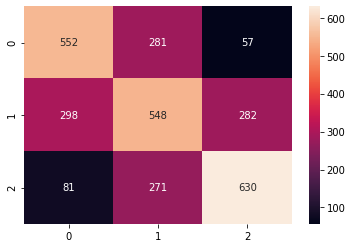

In [138]:
sns.heatmap(cm, annot=True, fmt='')